In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import math
from ngboost import NGBRegressor
from gamma import Gamma

# Expérience 1

In [2]:
n_samples=1000
alpha = np.random.uniform(1,10,n_samples)
beta = np.random.uniform(1,10,n_samples)
Params = np.stack([alpha,1/beta]).T
y = np.array([np.random.gamma(*params,size =1) for params in Params])
X = np.stack([alpha,beta]).T
X_train, X_test, y_train, y_test = train_test_split(X,y)
y_train = y_train.T[0]
y_test =y_test.T[0]

In [3]:
def train_model(max_depth=3,n_estimators=500,ordinary_gradient=False,early_stopping_rounds=None) :
    tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth)

    if ordinary_gradient :
        model = NGBRegressor(Dist=Gamma,Base=tree,n_estimators=n_estimators,natural_gradient=False)
    else :
        model = NGBRegressor(Dist=Gamma,Base=tree,n_estimators=n_estimators)

    if early_stopping_rounds is not None :
        model.fit(X_train,y_train,
                  X_val=X_test,
                  Y_val=y_test,
                  early_stopping_rounds=early_stopping_rounds
                )
    else :
        model.fit(X_train,y_train,
                  X_val=X_test,
                  Y_val=y_test
                )
    
    return model



models_natural = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_natural.append(train_model(n_estimators = iterations,early_stopping_rounds= 3))
    if len(models_natural) >= 2 :
        if len(models_natural[-1].base_models) == len(models_natural[-2].base_models) :
            models_natural.pop(-1)
            break
    iterations += 50


models_ordinary = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_ordinary.append(train_model(n_estimators = iterations,early_stopping_rounds= 3,ordinary_gradient=True))
    if len(models_ordinary) >= 2 :
        if len(models_ordinary[-1].base_models) == len(models_ordinary[-2].base_models) :
            models_ordinary.pop(-1)
            break
    if iterations >= 800 :
        break
    iterations += 50

Number of iterations : 0
Number of iterations : 50
[iter 0] loss=1.4308 val_loss=1.3898 scale=1.0000 norm=1.5488
Number of iterations : 100
[iter 0] loss=1.4308 val_loss=1.3898 scale=1.0000 norm=1.5488
Number of iterations : 150
[iter 0] loss=1.4308 val_loss=1.3898 scale=1.0000 norm=1.5488
[iter 100] loss=0.7449 val_loss=0.7825 scale=1.0000 norm=1.0851
Number of iterations : 200
[iter 0] loss=1.4308 val_loss=1.3898 scale=1.0000 norm=1.5488
[iter 100] loss=0.7449 val_loss=0.7825 scale=1.0000 norm=1.0851
Number of iterations : 250
[iter 0] loss=1.4308 val_loss=1.3898 scale=1.0000 norm=1.5488
[iter 100] loss=0.7449 val_loss=0.7825 scale=1.0000 norm=1.0851
[iter 200] loss=0.5738 val_loss=0.6542 scale=1.0000 norm=1.1216
Number of iterations : 300
[iter 0] loss=1.4308 val_loss=1.3898 scale=1.0000 norm=1.5488
[iter 100] loss=0.7449 val_loss=0.7825 scale=1.0000 norm=1.0851
[iter 200] loss=0.5738 val_loss=0.6552 scale=1.0000 norm=1.1216
== Early stopping achieved.
== Best iteration / VAL256 (va

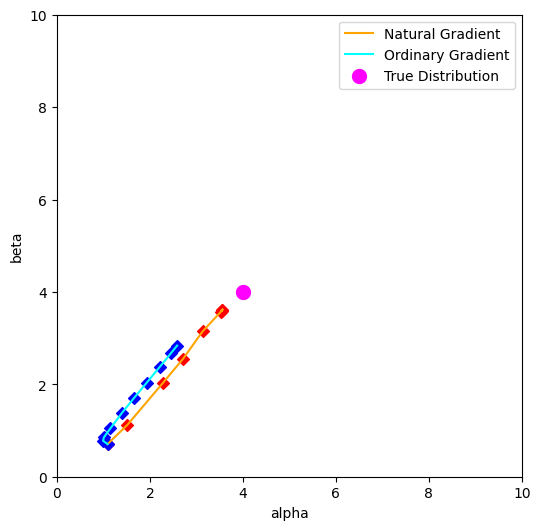

In [7]:
alpha0, beta0 = 4,4
objective = np.array([[alpha0,beta0]])

predictions_natural = []
for model in models_natural :
    predictions_natural.append(model.pred_dist(objective).params)
predictions_natural = np.array([np.stack([pred['alpha'], pred['beta']]).T[0] for pred in predictions_natural])

predictions_ordinary = []
for model in models_ordinary :
    predictions_ordinary.append(model.pred_dist(objective).params)
predictions_ordinary = np.array([np.stack([pred['alpha'], pred['beta']]).T[0] for pred in predictions_ordinary])



fig, ax = plt.subplots(figsize = (6,6))
ax.plot(predictions_natural[:,0],predictions_natural[:,1],color='orange',label = 'Natural Gradient')
ax.scatter(predictions_natural[:,0],predictions_natural[:,1],color='red',marker='D')

ax.plot(predictions_ordinary[:,0],predictions_ordinary[:,1],color='cyan',label= 'Ordinary Gradient')
ax.scatter(predictions_ordinary[:,0],predictions_ordinary[:,1],color='blue',marker='D')

ax.scatter(alpha0,beta0, marker = 'o', color = 'magenta',linewidths=5,label='True Distribution')

ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.legend()
plt.show()

# Expérience 2

In [66]:
def distribution(x) :
    alpha = x**2 + 2
    beta = np.abs(x) + 1
    return alpha, beta

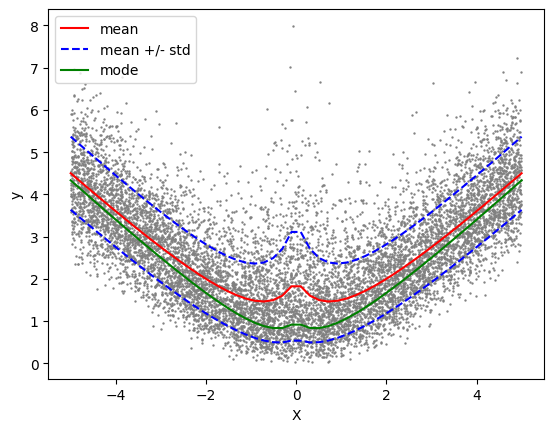

In [76]:
n_samples = 10000
X = np.random.uniform(-5,5,n_samples)[...,None]
y = np.array([[np.random.gamma(distribution(x[0])[0],1/distribution(x[0])[1])] for x in X])

X_train, X_val, y_train, y_val = train_test_split(X,y)
y_train = y_train.T[0]
y_val =y_val.T[0]

mean = np.array([distribution(x)[0]/distribution(x)[1] for x in np.linspace(-5,5)])
var = np.array([distribution(x)[0]/(distribution(x)[1]**2) for x in np.linspace(-5,5)])
mode = np.array([(distribution(x)[0]-1)/distribution(x)[1] for x in np.linspace(-5,5)])
plt.plot(np.linspace(-5,5),mean,'r',label='mean')
plt.plot(np.linspace(-5,5),mean+np.sqrt(var),'--b',label='mean +/- std')
plt.plot(np.linspace(-5,5),mean-np.sqrt(var),'--b')
plt.plot(np.linspace(-5,5),mode,'g',label='mode')
plt.scatter(X,y,color='grey',s=0.5)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

In [79]:
def train_model(max_depth=3,n_estimators=500,ordinary_gradient=False,early_stopping_rounds=None) :
    tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth)

    if ordinary_gradient :
        model = NGBRegressor(Dist=Gamma,Base=tree,n_estimators=n_estimators,natural_gradient=False)
    else :
        model = NGBRegressor(Dist=Gamma,Base=tree,n_estimators=n_estimators)

    if early_stopping_rounds is not None :
        model.fit(X_train,y_train,
                  X_val=X_val,
                  Y_val=y_val,
                  early_stopping_rounds=early_stopping_rounds
                )
    else :
        model.fit(X_train,y_train,
                  X_val=X_val,
                  Y_val=y_val
                )
    
    return model


models_natural = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_natural.append(train_model(n_estimators = iterations,early_stopping_rounds= 3))
    if len(models_natural) >= 2 :
        if len(models_natural[-1].base_models) == len(models_natural[-2].base_models) :
            models_natural.pop(-1)
            break
    iterations += 100

models_ordinary = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_ordinary.append(train_model(n_estimators = iterations,early_stopping_rounds= 3,ordinary_gradient=True))
    if len(models_ordinary) >= 2 :
        if len(models_ordinary[-1].base_models) == len(models_ordinary[-2].base_models) :
            models_ordinary.pop(-1)
            break
    if iterations >= 800 :
        break
    iterations += 100

Number of iterations : 0
Number of iterations : 100
[iter 0] loss=1.6761 val_loss=1.6598 scale=1.0000 norm=1.3650
Number of iterations : 200
[iter 0] loss=1.6761 val_loss=1.6598 scale=1.0000 norm=1.3650
[iter 100] loss=1.3801 val_loss=1.3851 scale=1.0000 norm=1.1679
Number of iterations : 300
[iter 0] loss=1.6761 val_loss=1.6598 scale=1.0000 norm=1.3650
[iter 100] loss=1.3801 val_loss=1.3851 scale=1.0000 norm=1.1679
[iter 200] loss=1.2705 val_loss=1.2813 scale=1.0000 norm=1.2252
Number of iterations : 400
[iter 0] loss=1.6761 val_loss=1.6598 scale=1.0000 norm=1.3650
[iter 100] loss=1.3801 val_loss=1.3851 scale=1.0000 norm=1.1679
[iter 200] loss=1.2705 val_loss=1.2813 scale=1.0000 norm=1.2252
[iter 300] loss=1.2313 val_loss=1.2484 scale=0.5000 norm=0.6354
Number of iterations : 500
[iter 0] loss=1.6761 val_loss=1.6598 scale=1.0000 norm=1.3650
[iter 100] loss=1.3801 val_loss=1.3851 scale=1.0000 norm=1.1679
[iter 200] loss=1.2705 val_loss=1.2813 scale=1.0000 norm=1.2252
[iter 300] loss=1.

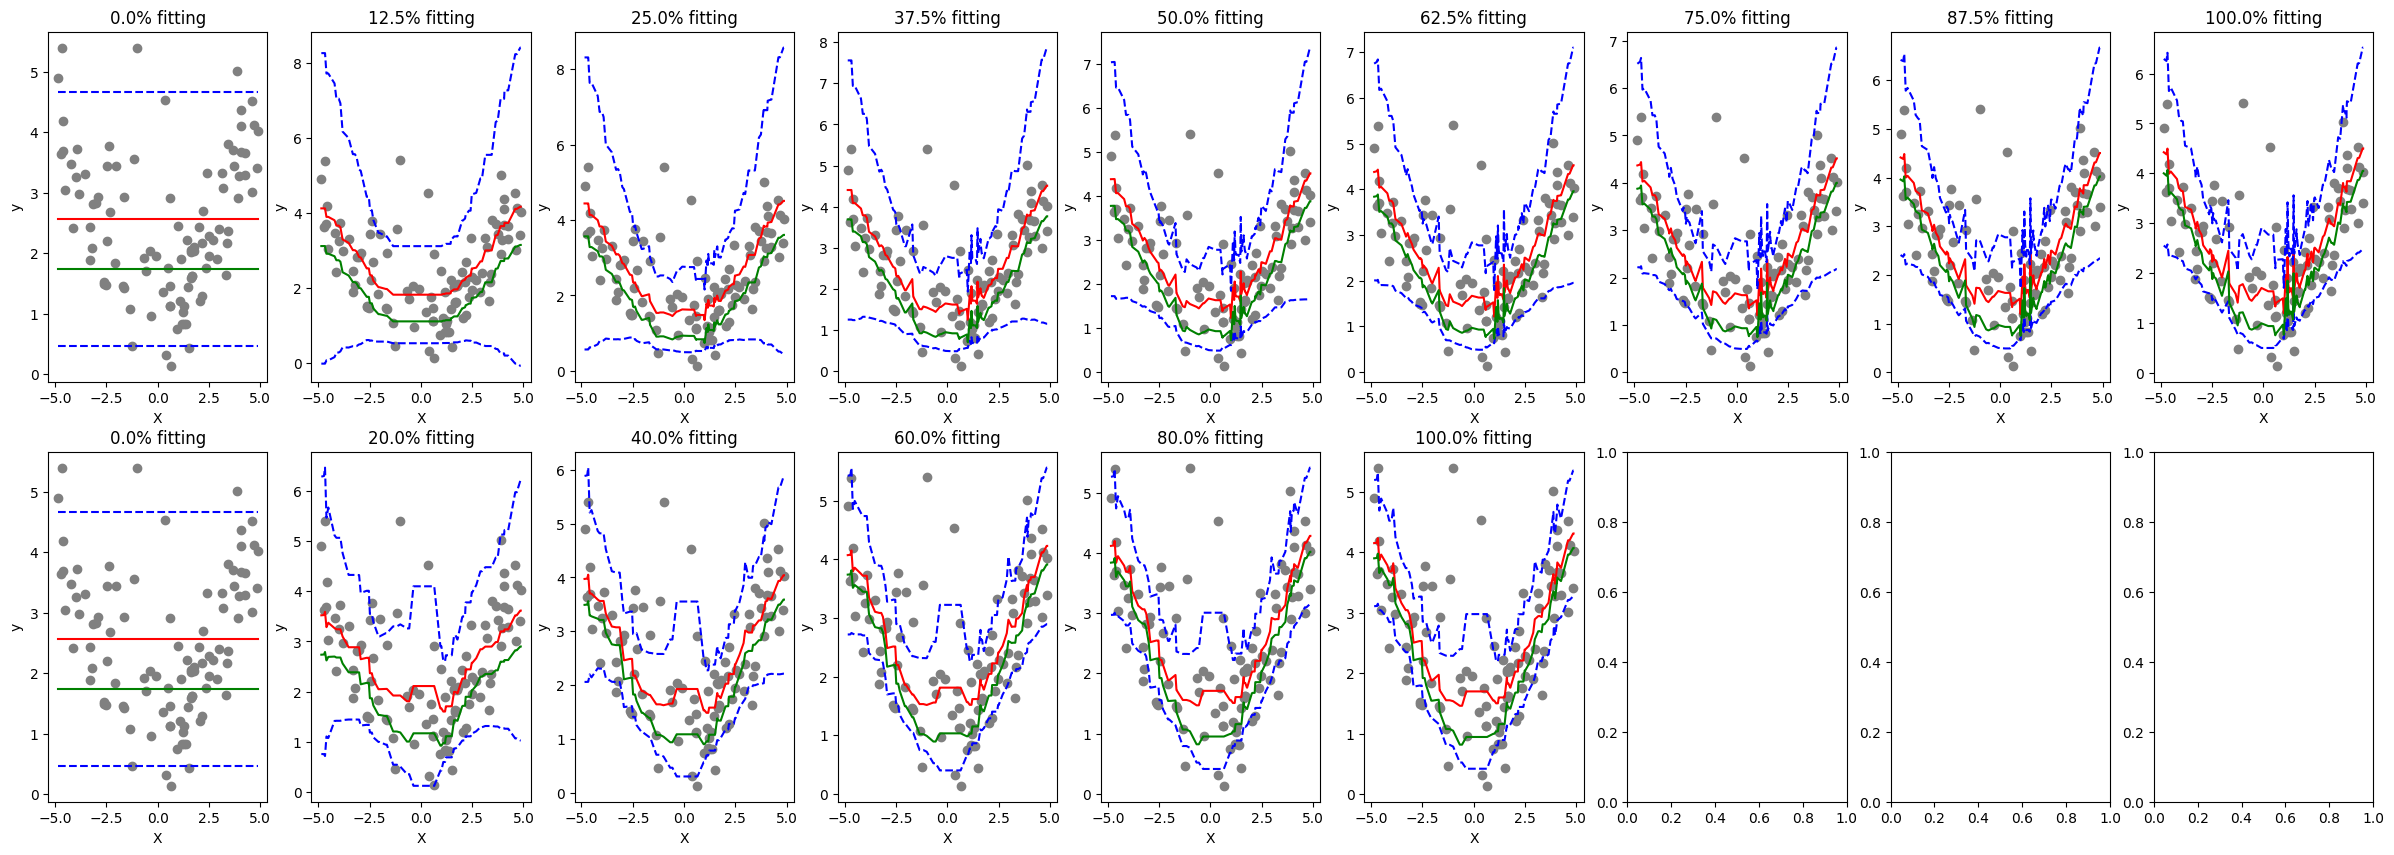

In [80]:
n_samples = 100
X = np.random.uniform(-5,5,n_samples)
X = np.sort(X)
y = np.array([[np.random.gamma(distribution(x)[0],1/distribution(x)[1])] for x in X])

X = X[...,None]
distribs_ordinary = [models_ordinary[i].pred_dist(X) for i in range(len(models_ordinary))]
distribs_natural = [models_natural[i].pred_dist(X) for i in range(len(models_natural))]



alpha_pred_ordinary = np.array([distribs.params['alpha'] for distribs in distribs_ordinary])
beta_pred_ordinary = np.array([distribs.params['beta'] for distribs in distribs_ordinary])
mean_pred_ordinary = alpha_pred_ordinary / beta_pred_ordinary
var_pred_ordinary = alpha_pred_ordinary / (beta_pred_ordinary**2)
mode_pred_ordinary = (alpha_pred_ordinary-1) / beta_pred_ordinary

alpha_pred_natural = np.array([distribs.params['alpha'] for distribs in distribs_natural])
beta_pred_natural = np.array([distribs.params['beta'] for distribs in distribs_natural])
mean_pred_natural = alpha_pred_natural / beta_pred_natural
var_pred_natural = alpha_pred_natural / (beta_pred_natural**2)
mode_pred_natural = (alpha_pred_natural-1) / beta_pred_natural

fig, axs = plt.subplots(2,max(len(distribs_natural), len(distribs_ordinary)),figsize = (30,10))
for i in range(len(distribs_ordinary)) :
    axs[0,i].scatter(X,y,color='grey')
    axs[0,i].plot(X,mean_pred_ordinary[i],color='red')
    axs[0,i].plot(X,(mean_pred_ordinary + var_pred_ordinary)[i],'--b')
    axs[0,i].plot(X,(mean_pred_ordinary - var_pred_ordinary)[i],'--b')
    axs[0,i].plot(X,mode_pred_ordinary[i],color='green')
    axs[0,i].set_xlabel('X')
    axs[0,i].set_ylabel('y')
    axs[0,i].set_title(f'{int(10000*i/(len(distribs_ordinary)-1))/100}% fitting')

for i in range(len(distribs_natural)) :
    axs[1,i].scatter(X,y,color='grey')
    axs[1,i].plot(X,mean_pred_natural[i],color='red')
    axs[1,i].plot(X,(mean_pred_natural + var_pred_natural)[i],'--b')
    axs[1,i].plot(X,(mean_pred_natural - var_pred_natural)[i],'--b')
    axs[1,i].plot(X,mode_pred_natural[i],color='green')
    axs[1,i].set_title(f'{int(10000*i/(len(distribs_natural)-1))/100}% fitting')
    axs[1,i].set_xlabel('X')
    axs[1,i].set_ylabel('y')